In [33]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
CaseName_Base = 'RTS24'
CaseName_ByStages = CaseName_Base + '_ByStages_nc'


Folder_A = 'A.The_full_year_MILP'
Folder_D = 'D.Representative_days_based_on_RES_and_Demand'
Folder_E = 'E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_F = 'F.Representative_days_based_on_Line_Benefit_NN_OC_fy_1'
Folder_G = 'G.Representative_days_based_on_Line_Benefit_NN_OC_fy_2'
# Folder_H = 'H.Representative_days_based_on_Line_Benefit_NN_OC_fy_3'
# Folder_I = 'I.Representative_days_based_on_Line_Benefit_NN_OC_fy_4'

DirName  = os.getcwd()
_path_0 = os.path.join(DirName, CaseName_Base)
category_dict = {Folder_A: "FYMILP",Folder_D: "R&D",Folder_E: "OPT_LB",Folder_F: "NN_OPCOST",Folder_G: "NN_LB",}
colors_dict = { "FYMILP": "Blue","R&D": "Red","OPT_LB": "Black","NN_OPCOST": "Orange" ,Folder_G: "Green"}

In [57]:
def LoadingData(dir, folder,result, case, ncluster, cm):
    if folder == 'A.The_full_year_MILP': 
        df = pd.read_csv(os.path.join(dir, folder, case, '3.Out', f'oT_Result_{result}_'+case+'.csv'), index_col=[0,1])
    else: 
        df = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '3.Out', f'oT_Result_{result}_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'), index_col=[0,1])

    df['CaseName'] = folder + ' - ' + case + str(ncluster)
    df['Clustering method'] = cm
#     df['Category2'] = cat2
#     df['Category3'] = cat3
    df['Number of clusters'] = ncluster
    df = df.reset_index()
#df = df.reset_index().set_index(['CaseName', 'Category1', 'Category2', 'Category3', 'Category4'])
    # df = df.set_index('CaseName', append=True)
    return df

In [58]:
result = "CostSummary"
nbs_clusters = [(i+1)*10 for i in range(10)]
#nbs_clusters = [(i+1)*10 for i in range(2)]
folders = [Folder_A,Folder_D]#,Folder_E]#,Folder_F,Folder_G]
#folders = [Folder_A,Folder_D]
results = ["CostSummary", "NetworkInvestment"]

results_dfs = dict()
for result in results :
    results_dfs[result] = dict()
    for folder in folders: 
        results_dfs[result][folder] = dict()
        for nb_clusters in nbs_clusters:
            results_dfs[result][folder][nb_clusters] = LoadingData(DirName, folder,result, CaseName_Base, nb_clusters, category_dict[folder])


In [59]:
#Concatenate results dataframes 
results_dfs_concat = dict()
for result in results:
    results_dfs_concat[result]=   pd.concat([results_dfs[result][folder][nb_clusters] for nb_clusters in nbs_clusters for folder in folders])

In [60]:
#Pivot the system cost dataframe and rename some columns
results_dfs_pivot = results_dfs_concat["CostSummary"].pivot_table(values = "MEUR",columns = "Cost/Payment",index = ["Clustering method", "Number of clusters"]).reset_index().set_index(["Clustering method", "Number of clusters"])
results_dfs_pivot.rename({"Total          System Cost" : "TSC",'Network    Investment Cost' : "NIC" },axis = 1,inplace=True)

In [61]:
#Calculate difference with respect to FYMILP
diff_cols = ["TSC","NIC"]
#results_dfs_pivot.loc["NN_LL","Diff TSC"] = results_dfs_pivot.loc["FYMILP",diff_col] - results_dfs_pivot.loc["NN_LL",diff_col]
for diff_col in diff_cols:
    results_dfs_pivot[f'Diff_{diff_col}'] = results_dfs_pivot[diff_col] - results_dfs_pivot.loc['FYMILP', diff_col]

In [62]:
# Add investment difference as column to existing pivot dataframe 
inv_diffs = pd.DataFrame()
#inv_diffs["Clustering method"] = results_dfs_concat["NetworkInvestment"]["Clustering method"]
inv_diffs["pu"] = results_dfs_concat["NetworkInvestment"].reset_index().set_index(["Clustering method","InitialNode","FinalNode","Circuit", "Number of clusters"])["p.u."] -results_dfs_concat["NetworkInvestment"].reset_index().set_index(["Clustering method","InitialNode","FinalNode","Circuit","Number of clusters"]).loc["FYMILP"]["p.u."]
inv_diffs["pu_abs"] = inv_diffs["pu"].abs()
results_dfs_pivot["Investment difference"] = inv_diffs.groupby(["Clustering method", "Number of clusters"]).sum()["pu"]
results_dfs_pivot["Investment difference abs"] = inv_diffs.groupby(["Clustering method", "Number of clusters"]).sum()["pu_abs"]

In [63]:
results_dfs_pivot

Cost/Payment                          Consumption Operation Cost   
Clustering method Number of clusters                               
FYMILP            10                                         0.0  \
                  20                                         0.0   
                  30                                         0.0   
                  40                                         0.0   
                  50                                         0.0   
                  60                                         0.0   
                  70                                         0.0   
                  80                                         0.0   
                  90                                         0.0   
                  100                                        0.0   
R&D               10                                         0.0   
                  20                                         0.0   
                  30                                         0.0   
                  40                                         0.0   
                  50                                         0.0   
                  60                                         0.0   
                  70                                         0.0   
                  80                                         0.0   
                  90                                         0.0   
                  100                                        0.0   

Cost/Payment                          Emission              Cost   
Clustering method Number of clusters                               
FYMILP            10                                   48.918927  \
                  20                                   48.918927   
                  30                                   48.918927   
                  40                                   48.918927   
                  50                                   48.918927   
                  60                                   48.918927   
                  70                                   48.918927   
                  80                                   48.918927   
                  90                                   48.918927   
                  100                                  48.918927   
R&D               10                                   45.890729   
                  20                                   44.945322   
                  30                                   46.987840   
                  40                                   44.812910   
                  50                                   50.925239   
                  60                                   47.653532   
                  70                                   47.572333   
                  80                                   47.806115   
                  90                                   49.923060   
                  100                                  49.588207   

Cost/Payment                          Generation  Operation Cost   
Clustering method Number of clusters                               
FYMILP            10                                   39.030505  \
                  20                                   39.030505   
                  30                                   39.030505   
                  40                                   39.030505   
                  50                                   39.030505   
                  60                                   39.030505   
                  70                                   39.030505   
                  80                                   39.030505   
                  90                                   39.030505   
                  100                                  39.030505   
R&D               10                                   38.915655   
                  20                                   37.133035   
                  30                                  

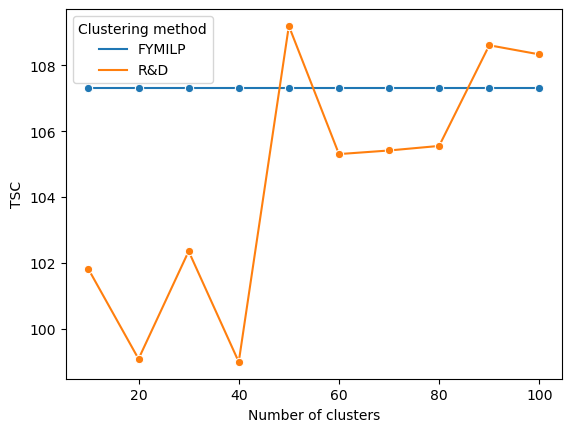

In [65]:
#Regular line plots
y = "NIC"
y = "TSC"
#y= 'Investment difference abs'
#y = 'Difference_from_FYMILP'
x = "Number of clusters"
sns.lineplot(data = results_dfs_pivot,x = x, y = y,hue = "Clustering method",marker = "o")
plt.savefig(f"Z.Figures/lineplot_{y}_{x}_{CaseName_Base}")

<Axes: xlabel='Number of clusters', ylabel='TSC'>

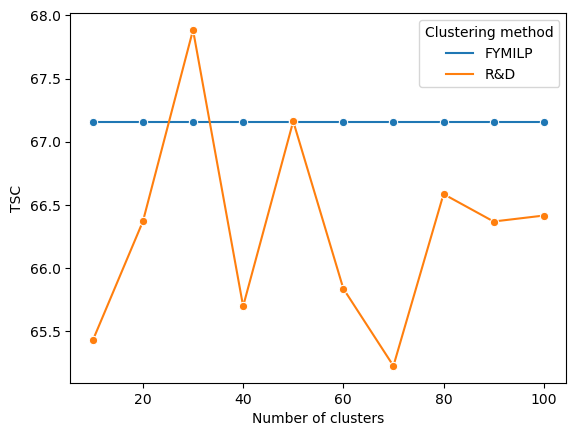

In [45]:
#Regular line plots
y = "NIC"
y = "TSC"
#y= 'Investment difference abs'
#y = 'Difference_from_FYMILP'
x = "Number of clusters"
sns.lineplot(data = results_dfs_pivot,x = x, y = y,hue = "Clustering method",marker = "o")

<Axes: xlabel='Diff_NIC', ylabel='Diff_TSC'>

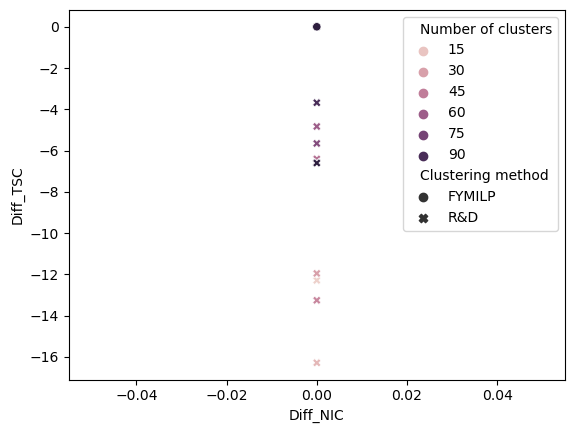

In [14]:
#Scatter plot with NIC vs TSC 
reindexed = results_dfs_pivot.reset_index()
y = "Diff_TSC"
x= 'Diff_NIC'

sns.scatterplot(data = reindexed,x = x, y = y,hue = "Number of clusters",style = "Clustering method" )

In [387]:
y = 
y.to_numpympy()

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100,  10,  20,  30,
        40,  50,  60,  70,  80,  90, 100,  10,  20,  30,  40,  50,  60,
        70,  80,  90, 100,  10,  20,  30,  40,  50,  60,  70,  80,  90,
       100,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100], dtype=int64)

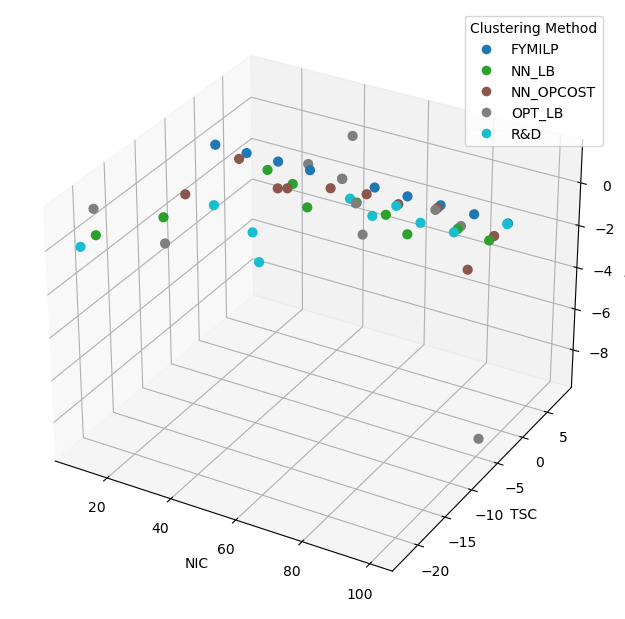

In [407]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
n = 200
x = reindexed["NIC"].to_numpy()
y = reindexed["TSC"].to_numpy()

z = reindexed["Diff_NIC"].to_numpy()
y = reindexed["Diff_TSC"].to_numpy()
x = reindexed["Number of clusters"].to_numpy()
c= reindexed["Clustering method"].to_numpy()

unique_categories = np.unique(c)
num_categories = len(unique_categories)

# Mapping each category to a unique color using a colormap
colors = plt.cm.tab10(np.linspace(0, 1, num_categories))

# Creating a dictionary to map category to color
category_to_color = {category: color for category, color in zip(unique_categories, colors)}

# Mapping the 'c' array to colors
point_colors = [category_to_color[category] for category in c]


# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# plot
sc = ax.scatter(x, y, z, s=40, c=point_colors, marker='o', alpha=1)
ax.set_xlabel('NIC')
ax.set_ylabel('TSC')
ax.set_zlabel('Nb clust')

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=8) for category, color in category_to_color.items()]
ax.legend(handles=legend_elements, title='Clustering Method', loc='upper right')
